In [17]:
pip install bootstrapped

Note: you may need to restart the kernel to use updated packages.


In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats
from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower

In [55]:
data = pd.read_csv('HR-Employee-Attrition.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Знакомство с данными. 1470 строк, 35 столбцов, без пропусков, числовые и категориальные данные. Дубликатов записей нет. 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [11]:
data.duplicated().sum()

0

Продолжение знакомства с данными, распределения и вид данных. 

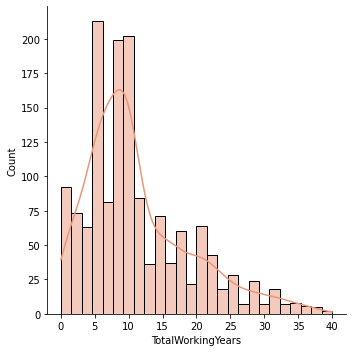

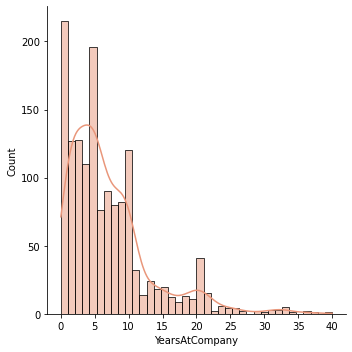

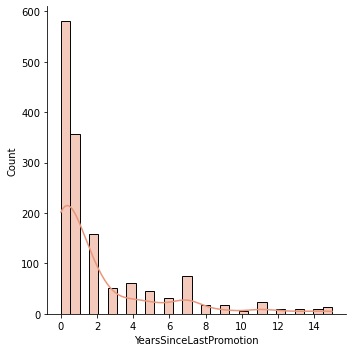

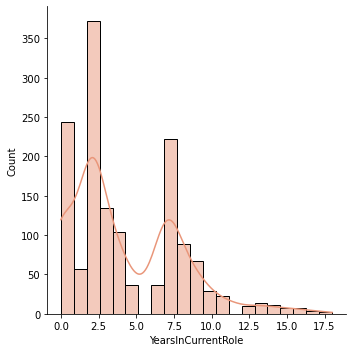

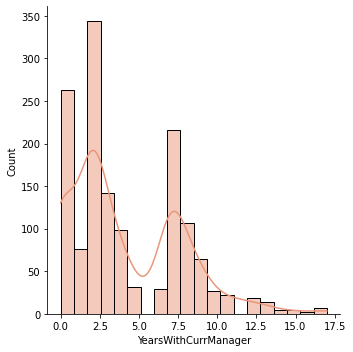

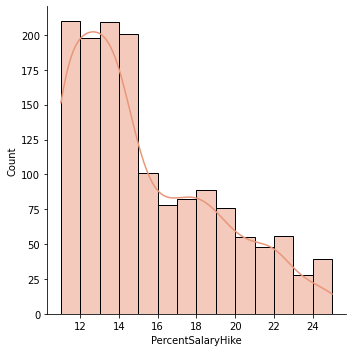

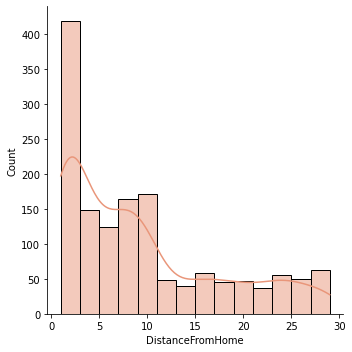

In [6]:
sns.displot(data['TotalWorkingYears'], kde=True, color='darksalmon') 
sns.displot(data['YearsAtCompany'], kde=True, color='darksalmon') 
sns.displot(data['YearsSinceLastPromotion'], kde=True, color='darksalmon') 
sns.displot(data['YearsInCurrentRole'], kde=True, color='darksalmon') 
sns.displot(data['YearsWithCurrManager'], kde=True, color='darksalmon') 
sns.displot(data['PercentSalaryHike'], kde=True, color='darksalmon') 
sns.displot(data['DistanceFromHome'], kde=True, color='darksalmon') 
plt.show()

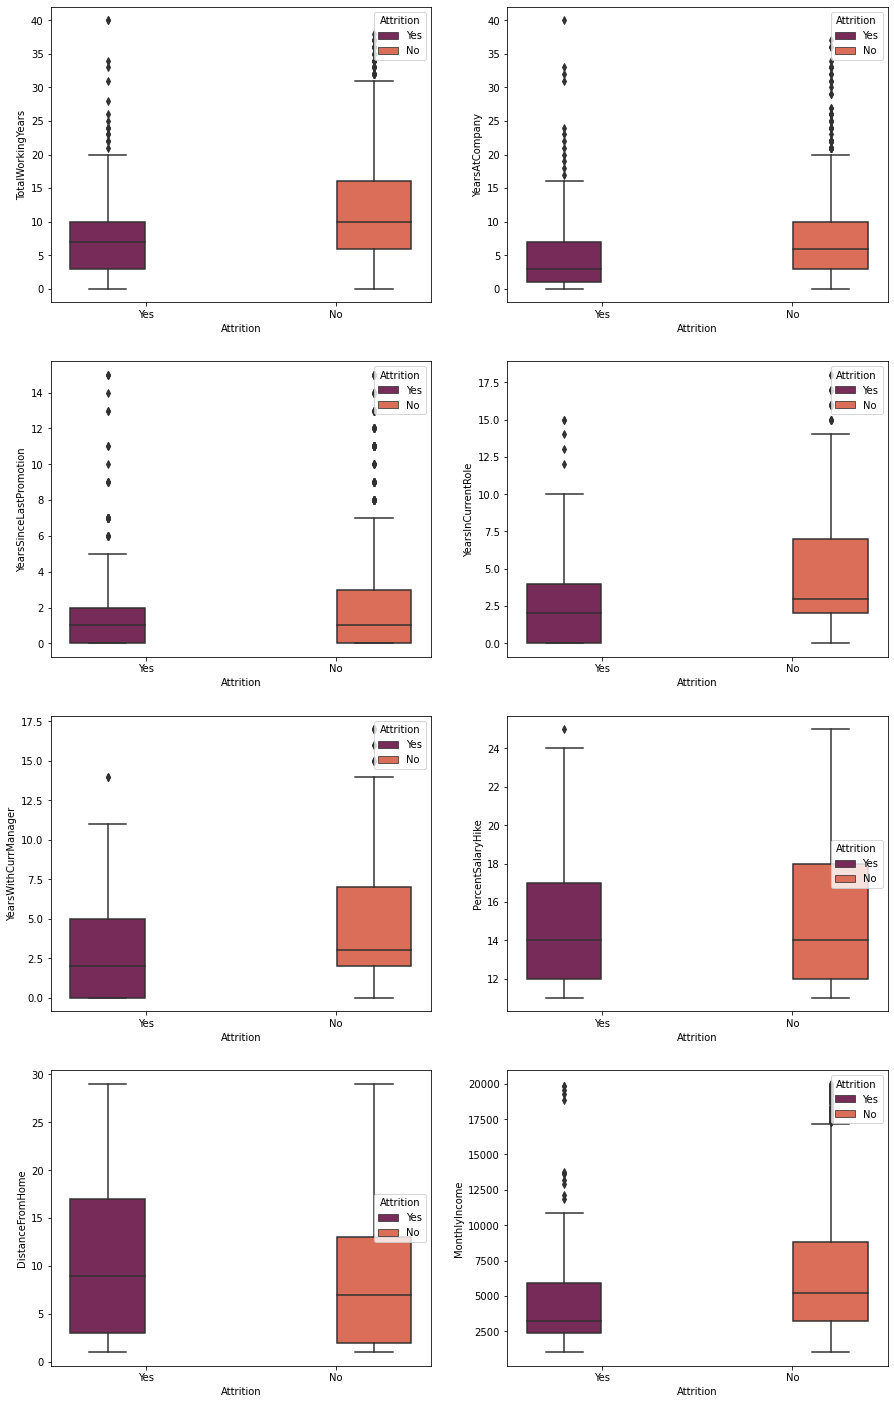

In [7]:
columns = ["TotalWorkingYears","YearsAtCompany","YearsSinceLastPromotion","YearsInCurrentRole","YearsWithCurrManager",
           "PercentSalaryHike","DistanceFromHome","MonthlyIncome"] 
plt.figure(figsize=(15, 25))
k = 0
for i in columns:
  k += 1
  plt.subplot(4, 2, k)
  ax = sns.boxplot(data=data, y=i, x="Attrition", hue="Attrition", palette="rocket")

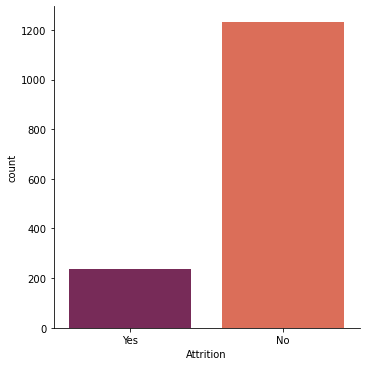

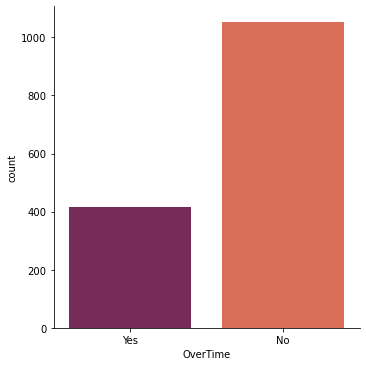

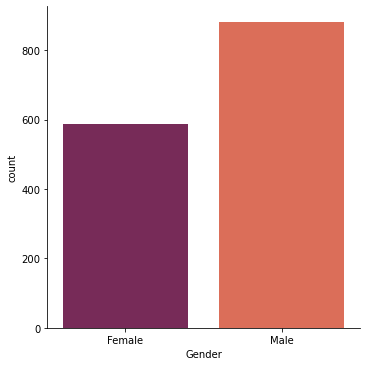

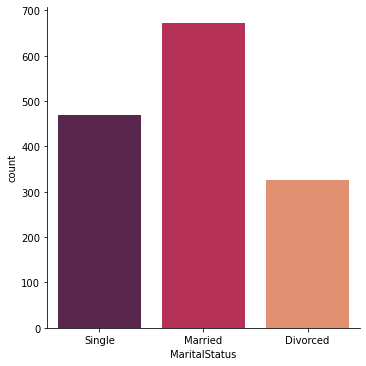

In [8]:
sns.catplot(x="Attrition", kind="count", palette="rocket", data=data)
sns.catplot(x="OverTime", kind="count", palette="rocket", data=data)
sns.catplot(x="Gender", kind="count", palette="rocket", data=data)
sns.catplot(x="MaritalStatus", kind="count", palette="rocket", data=data)

В данных есть колонка истощение/увольнение работников. Я думаю, что чаще увольняются те работники, которые дальше живут и дольше добираются до работы. Я буду исследовать данные о расстоянии до дома в двух выборках: продолжающих работать сотрудников и уволившихся. Это две независимые пространственные выборки.

<AxesSubplot:xlabel='Attrition', ylabel='DistanceFromHome'>

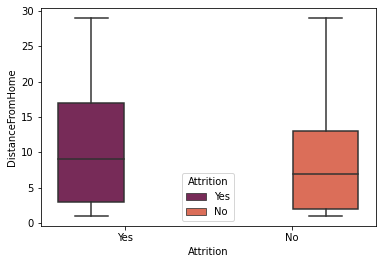

In [12]:
sns.boxplot(data=data, y="DistanceFromHome", x="Attrition", hue="Attrition", palette="rocket")

По боксплоту видно, что медианное значение расстояние больше для тех работников, которые уволились. Сравним средние значения для этих двух групп (группа А - уволившиеся сотрудники, группа В - продолжающие работу в компании). 

In [13]:
group_A = data.loc[data.Attrition == 'Yes']['DistanceFromHome']
group_B = data.loc[data.Attrition == 'No']['DistanceFromHome']

In [41]:
len(group_A), len(group_B)

(237, 1233)

In [14]:
pd.Series(group_A).mean(), pd.Series(group_B).mean()

(10.632911392405063, 8.915652879156529)

Да, и вправду есть разница. Осталось понять, статзначима ли она. Посмотрим распределения данных о расстоянии до дома для каждой из этих групп. 

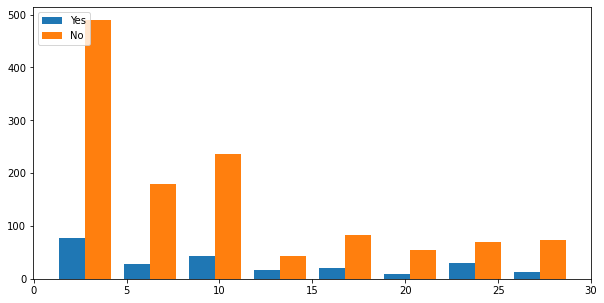

In [15]:
plt.figure(figsize=(10,5))
plt.hist([group_A, group_B], bins = 8, label=['Yes', 'No'])
plt.legend(loc='upper left')
plt.show()

Распределение данных имеет ненормальный вид распределения. Применим библиотеку bootstrapped для нормализации. 

In [29]:
bs_a = bs.bootstrap(group_A.values, stat_func=bs_stats.mean, 
             num_iterations=1000, iteration_batch_size=40, 
             return_distribution=True)

bs_b = bs.bootstrap(group_B.values, stat_func=bs_stats.mean, 
             num_iterations=1000, iteration_batch_size=40, 
             return_distribution=True)

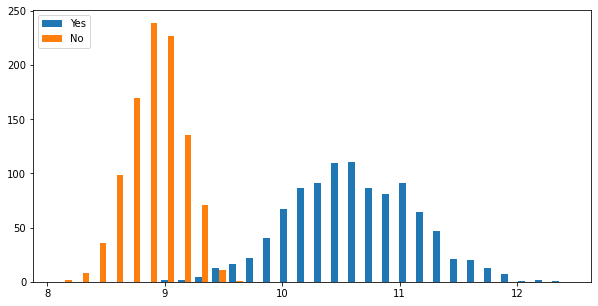

In [30]:
plt.figure(figsize=(10,5))
plt.hist([bs_a, bs_b], bins = 30, label=['Yes', 'No'])
plt.legend(loc='upper left')
plt.show()

Получились вот такие красивые графики, похожие на нормальное распределение. Проверим правда ли они нормальные с помощью критерия Шапиро. Он обладает большей мощностью, чем критерий Колмогорова-Смирнова.

In [26]:
alpha = 0.05

st = shapiro(pd.Series(bs_a))
print('Distribution A is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))
st = shapiro(pd.Series(bs_b))
print('Distribution B is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Distribution A is normal

Distribution B is normal



Проверим равенство дисперсий для этих двух выборок с помощью F-критерия Фишера. Этот критерий параметрический, основан на предположении о равенстве выборок нормальному закону.

In [35]:
alpha = 0.05

p_value = f_oneway(bs_a, bs_b)[1]
print('{} the H0: Var(X1) == Var(X2)\n'.format({True:'Reject', False:'Confirm'}[p_value > alpha]))

Confirm the H0: Var(X1) == Var(X2)



Теперь можно проверить с помощью t-критерия Стьюдента статзначима ли разница в этих выборках. 

In [34]:
st = ttest_ind(bs_a, bs_b)
print('Diffs is {}significant\n'.format({True:'not ',False:''}[st[1] > alpha]))

Diffs is significant



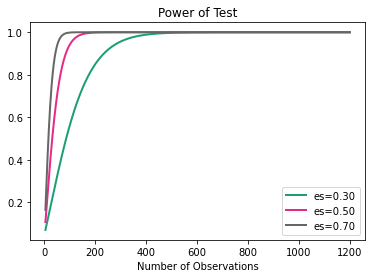

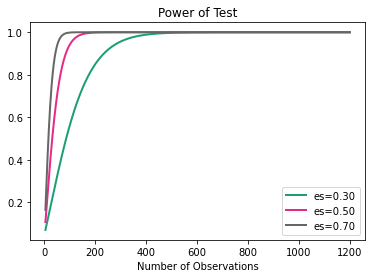

In [53]:
analysis = TTestIndPower()
analysis.plot_power(nobs=np.arange(5, 1200), effect_size=np.array([0.3, 0.5, 0.7]))

In [54]:
effect = 0.3
alpha = 0.05
power = 0.8

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 175.385


Размер выборки для группы А данных при заданных значениях эффекта достаточен. 175 рассчитанный размер выборки, 217 исхожный размер выборки. Выдвинутая гипотеза подтвердилась. 